# 1次元データセットを通した勾配法の理解
- 参考
  - [Pythonで動かして学ぶ！あたらしい機械学習の教科書 第2版](https://www.shoeisha.co.jp/book/detail/9784798159911), 5.1節

## 達成目標
- モデル設計、コスト関数設計、最適パラメータの探索を通した「学習のイメージ」を掴む。
- 勾配法を理解する。
  - 勾配法自体は機械学習オリジナルの話ではありません。古くは[オペレーションズ・リサーチ](https://ja.wikipedia.org/wiki/オペレーションズ・リサーチ)等における何かしらの最適解を効率よく求める科学技術における古典的（代表的）なアルゴリズムの一つ。

## 全体の流れ
- step 1: 動作確認用のデータセットを用意（手動作成）する。
- step 2: 線形回帰モデルによるMSE空間の観察。
- step 3: 勾配法によるパラメータ探索の様子を確認。
- step 4: 探索により得たパラメータの良し悪しを確認。

In [1]:
from typing import List, Union, Any

import numpy as np
import matplotlib.pyplot as plt

## step 1: 動作確認用のデータセットを用意（手動作成）する。

In [2]:
def true_function(x: np.ndarray) -> np.ndarray:
    """真のモデル
    本来は取得し得ない真のモデルを関数として表現したもの。
    Arguments:
        x (np.ndarray): サンプリング点の集合。
    Returns:
        np.ndarray: サンプリング点に対する真の値。
    """
    return 170 - 108 * np.exp(-0.2*x)

def make_dataset(num_of_samples: int, x_min: float, x_max: float,
                random_seed=0) -> Any:
    """真のモデルを用いてデータセットを作成。
    サンプリングの範囲は[x_min, x_max)。
    Arguments:
        num_of_samples (int): サンプル数。
        x_min, x_max (float): サンプリング範囲。
        random_seed (int): シード値。
    Returns:
        x (np.ndarray): サンプル点。
        teach (np.ndarray): サンプル点に対する観測値。true_funcionにノイズを付与。
    """
    np.random.seed(random_seed)
    x = np.random.rand(num_of_samples) * (x_max - x_min) + x_min
    noisy = np.random.rand(num_of_samples) * 2
    teach = true_function(x) + noisy
    return x, teach

num_of_samples = 20
x_min = -1.0
x_max = 1.0
x, teach = make_dataset(num_of_samples, x_min, x_max)
print(len(x), x)
print(len(teach), teach)

20 [ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243 ]
20 [66.04552636 72.50564637 67.2723329  65.48271027 58.88756061 69.40209033
 59.55653639 79.55445243 81.32617169 57.67476978 74.4241239  64.78954195
 65.81218245 80.04281038 41.82152035 43.84192567 40.37520695 76.68817051
 75.25949882 78.22153279]


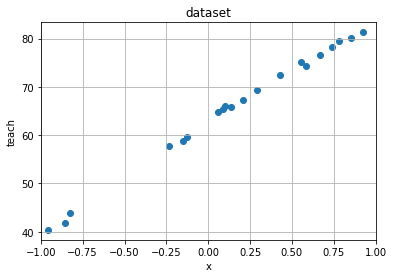

In [3]:
def plot_rawdata(raw_x: np.ndarray, raw_teach: np.ndarray, x_min: float, x_max: float) -> None:
    """データセットを描画。
    Arguments:
        raw_x (np.ndarray): 入力値。
        raw_teach (np.ndarray): 観測値。
        x_min, x_max (float): 定義域（データセットのサンプリング範囲）。
    """
    plt.figure()
    plt.scatter(raw_x, raw_teach)
    plt.title("dataset")
    plt.xlabel("x")
    plt.ylabel("teach")
    plt.xlim(x_min, x_max)
    plt.grid(True)
    plt.show()
    #plt.savefig("rawdata.svg")

plot_rawdata(x, teach, x_min, x_max)

## step 2: 線形回帰モデルによるMSE空間の観察。

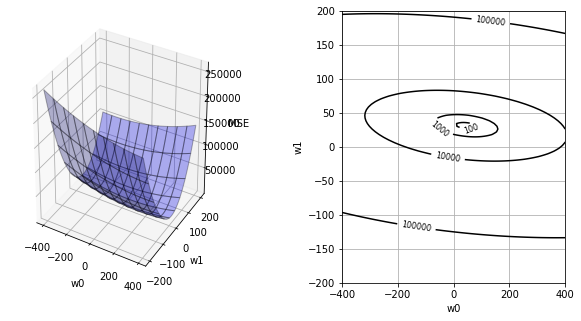

In [4]:
def model(input: np.ndarray, weights: List[Union[float, int]]) -> np.ndarray:
    """回帰モデルによる予測。
    Arguments:
        input (np.ndarray): モデルに対する入力。
        weights (list[number]): モデルの重み。
    Returns:
        predicted (np.ndarray): 入力に対する予測結果。
    """
    predicted = weights[0] + weights[1] * input
    return predicted

def calc_mse(input: np.ndarray, teach: np.ndarray, weights: List[Union[int, float]]):
    """MSE (Mean Squared Error) 算出。
    Arguments:
        input (np.ndarray): データセット（入力）。
        teach (np.ndarray): データセット（出力、観測値）。
        weights (list[number]): モデルの重み。
    Returns:
        mse (np.ndarray): MSE。
    """
    predicted = model(input, weights)
    mse = np.mean((predicted - teach)**2)
    return mse

def plot_mse(input: np.ndarray, teach: np.ndarray, weights_history=[None]):
    """重みに伴うMSE起伏の描画。
    Argumtns:
        input (np.ndarray): データセット（入力）。
        teach (np.ndarray): データセット（出力、観測値）。
        weights_history (np.ndarray): 勾配法による探索点移動のヒストリ。
    """
    dots = 100
    w0 = np.linspace(-400, 400, dots)
    w1 = np.linspace(-200, 200, dots)
    ww0, ww1 = np.meshgrid(w0, w1)
    MSE = np.zeros((len(w0), len(w1)))
    for i0 in range(dots):
        for i1 in range(dots):
            weights = [w0[i0], w1[i1]]
            MSE[i0, i1] = calc_mse(input, teach, weights)
    fig = plt.figure(figsize=(10, 5))
    plt.subplots_adjust(wspace=0.5)
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(ww0, ww1, MSE, rstride=10, cstride=10, alpha=0.3, color='blue', edgecolor='black')
    ax1.set_xlabel("w0")
    ax1.set_ylabel("w1")
    ax1.set_zlabel("MSE")
    ax2 = fig.add_subplot(1, 2, 2)
    if len(weights_history) == 1:
        cont = ax2.contour(ww0, ww1, MSE, 30, colors='black', levels=[100, 1000, 10000, 100000])
        ax2.set_xlabel("w0")
        ax2.set_ylabel("w1")
        cont.clabel(fmt='%1.0f', fontsize=8)
        ax2.grid(True)    
        #plt.show()
        plt.savefig('mse.svg')
    else:
        cont = ax2.contour(ww0, ww1, MSE, 30, colors='black', levels=[100, 1000, 10000, 100000])
        ax2.set_xlabel("w0")
        ax2.set_ylabel("w1")
        cont.clabel(fmt='%1.0f', fontsize=8)
        ax2.grid(True)
        ax2.scatter(weights_history[:,0], weights_history[:,1])
        plt.show()
        #plt.savefig('mse-history.svg')

plot_mse(x, teach)

## step 3: 勾配法によるパラメータ探索の様子を確認。

# begin gradin_descent
history_id, [w0, w1], (slope0, slope1)
0 [ 300. -150.] (209.5843370987155, -18.219739876727658)
1 [ 195.20783145 -140.89013006] (106.27807623785165, -32.29587907509851)
2 [ 142.06879333 -124.74219052] (55.77292286969848, -35.61643748697637)
3 [ 114.1823319  -106.93397178] (30.791153744219667, -34.268302684684514)
4 [ 98.78675502 -89.79982044] (18.190322284246538, -31.105982356045622)
5 [ 89.69159388 -74.24682926] (11.632004074773572, -27.439559699578734)
6 [ 83.87559185 -60.52704941] (8.053830513663275, -23.845290405750553)
7 [ 79.84867659 -48.60440421] (5.971613731562999, -20.554273880259718)
8 [ 76.86286972 -38.32726727] (4.6621070652754835, -17.63830584600503)
9 [ 74.53181619 -29.50811434] (3.769542470784592, -15.098311214151176)


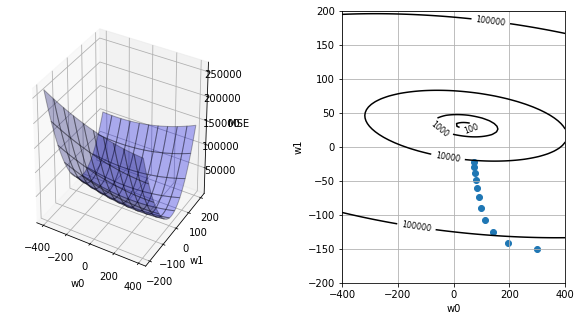

In [5]:
def calc_slope(input: np.ndarray, teach: np.ndarray, weights: List[Union[int, float]]):
    """重み空間における傾きの算出。
    Argumtns:
        input (np.ndarray): データセット（入力）。
        teach (np.ndarray): データセット（出力、観測値）。
        weights (list[number]): モデルの重み。
    Returns:
        slope_w0, slope_w1 (float): 各変数に対する傾き。
    """
    predicted = model(input, weights)
    slope_w0 = np.mean(predicted - teach)
    slope_w1 = np.mean((predicted - teach) * input)
    return slope_w0, slope_w1

def gradient_descent(input: np.ndarray, teach: np.ndarray, alpha=0.5):
    """勾配法による適正重み探索。
    Arguments:
        input (np.ndarray): データセット（入力）。
        teach (np.ndarray): データセット（出力、観測値）。
        alpha (float > 0): 学習率（移動幅調整用パラメータ）。
    Returns:
        weights_history (np.ndarray): 探索した重みの履歴。
    """
    moving_max_count = 10
    weights_history = np.zeros((moving_max_count+1, 2))
    weights_history[0][0] = 300.
    weights_history[0][1] = -150.
    print("# begin gradin_descent")
    print("history_id, [w0, w1], (slope0, slope1)")
    for i in range(moving_max_count):
        slope = calc_slope(input, teach, weights_history[i])
        print(i, weights_history[i], slope)
        weights_history[i+1][0] = weights_history[i][0] - alpha * slope[0]
        weights_history[i+1][1] = weights_history[i][1] - alpha * slope[1]
    return weights_history

weights_history = gradient_descent(x, teach)
plot_mse(x, teach, weights_history)

## step 4: 探索により得たパラメータの良し悪しを確認。

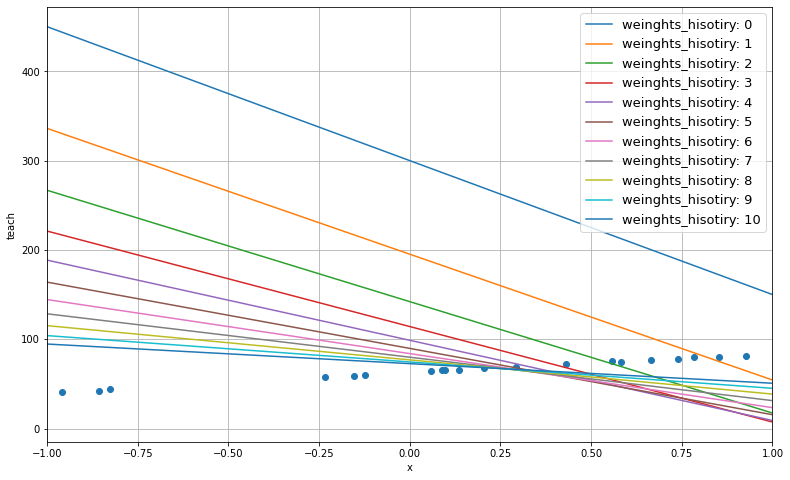

In [6]:
def plot_predictive_model(input, teach, x_min, x_max, weights_history):
    """重み履歴を用いた予測モデルの描画。
    Arguments:
        input (np.ndarray): データセット（入力）。
        teach (np.ndarray): データセット（出力、観測値）。
        x_min, x_max (float): データセット範囲。
        weights_history (np.ndarray): 探索した重みの履歴。
    """
    base = np.linspace(x_min, x_max, 100)
    predicted = []
    for i in range(len(weights_history)):
        w0 = weights_history[i][0]
        w1 = weights_history[i][1]
        predicted.append(w0 + w1 * base)
    plt.figure(figsize=(13,8))
    for i in range(len(weights_history)):
        line, = plt.plot(base, predicted[i])
        line.set_label('weinghts_hisotiry: {}'.format(i))
    plt.scatter(input, teach)
    plt.xlabel("x")
    plt.ylabel("teach")
    plt.xlim(x_min, x_max)
    plt.grid(True)
    plt.legend(loc='upper right', fontsize=13)
    plt.savefig('predicted_mode.svg')

plot_predictive_model(x, teach, x_min, x_max, weights_history)